In [91]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio
from datetime import datetime 
from tqdm import tqdm


In [92]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [136]:
# Util functions for loading audio files and ensure the correct sample rate

@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    print(sample_rate)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=18000)
    return wav

In [94]:
testing_wav_file_name = '/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanSound8K/audio/fold1/21684-9-0-7.wav'
testing_wav_file_name2 = '/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanSound8K/audio/fold1/7383-3-0-0.wav'


In [135]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)
testing_wav_data2 = load_wav_16k_mono(testing_wav_file_name2)

Tensor("DecodeWav:1", shape=(), dtype=int32)
Tensor("DecodeWav:1", shape=(), dtype=int32)


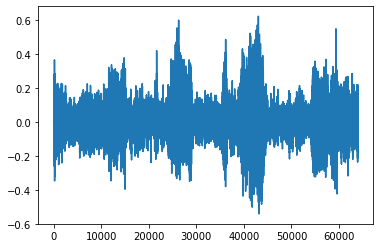

In [96]:
_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

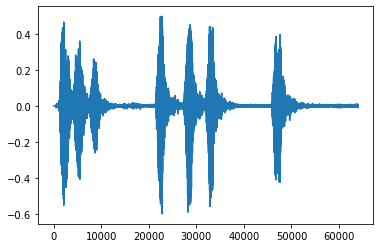

In [97]:
_ = plt.plot(testing_wav_data2)

# Play the audio file.
display.Audio(testing_wav_data2,rate=16000)

In [99]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
  print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


In [100]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data2)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]

print(f'The main sound is: {infered_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (8, 1024)


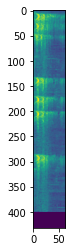

In [101]:
plt.figure()
plt.imshow(spectrogram)


In [117]:
US8K_AUDIO_PATH = os.path.abspath('../UrbanSound8K/audio/')
US8K_METADATA_PATH = os.path.abspath('../UrbanSound8K/metadata/UrbanSound8K.csv')

In [118]:
# load the csv metadata file into a Pandas DataFrame structure
us8k_metadata_df = pd.read_csv(US8K_METADATA_PATH,
                               usecols=["slice_file_name", "fold", "classID"],
                               dtype={"fold": "uint8", "classID" : "uint8"})

us8k_metadata_df

,slice_file_name,fold,classID
0,100032-3-0-0.wav,5,3
1,100263-2-0-117.wav,5,2
2,100263-2-0-121.wav,5,2
3,100263-2-0-126.wav,5,2
4,100263-2-0-137.wav,5,2
...,...,...,...
8726,99812-1-2-0.wav,7,1
8727,99812-1-3-0.wav,7,1
8728,99812-1-4-0.wav,7,1
8729,99812-1-5-0.wav,7,1


In [113]:
len(us8k_metadata_df)

8731

In [119]:
us8k_metadata_df['slice_file_name'][1]

'100263-2-0-117.wav'

In [120]:
for ligne in range(len(us8k_metadata_df)) :
    
    file_path = US8K_AUDIO_PATH +"/fold" + str(us8k_metadata_df['fold'][ligne]) + "/" + str(us8k_metadata_df['slice_file_name'][ligne])
    us8k_metadata_df["slice_file_name"][ligne] = file_path


   


<ipython-input-120-2a1ee5e65231>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us8k_metadata_df["slice_file_name"][ligne] = file_path


,slice_file_name,fold,classID
0,/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanS...,5,3
1,/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanS...,5,2
2,/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanS...,5,2
3,/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanS...,5,2
4,/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanS...,5,2
5,/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanS...,5,2
6,/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanS...,5,2
7,/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanS...,5,2
8,/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanS...,5,2
9,/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanS...,10,1


In [122]:
us8k_metadata_df['slice_file_name'][1000]

'/home/maxence/Documents/INSA/ASI4/s8/DL/UrbanSound8K/audio/fold1/122690-6-0-0.wav'

In [124]:
df = us8k_metadata_df

In [143]:
filenames = df['slice_file_name']
targets = df['classID']
folds = df['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [144]:
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

Tensor("DecodeWav:1", shape=(), dtype=int32)


(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [145]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,tf.repeat(label, num_embeddings),tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.uint8, name=None))

In [146]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 9)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 9)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 10)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)


In [147]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10)
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 10)                5130      
Total params: 529,930
Trainable params: 529,930
Non-trainable params: 0
_________________________________________________________________


In [148]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)
save_best = tf.keras.callbacks.ModelCheckpoint(filepath = "logs/checkpoints/", save_weights_only = True,
                                               monitor = "val_accuracy", mode = "max", save_best_only = True)

In [149]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=[callback,tensorboard_callback,save_best])

Epoch 1/20


InvalidArgumentError:  Bad format chunk size for WAV: Expected 16 or 18, but got40
	 [[{{node PartitionedCall/DecodeWav}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_50740]

Function call stack:
train_function
